In [1]:
# importando as bibliotecas
from pyspark.sql import Row
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from typing import Iterable 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# criando a Spark Session
spSession = SparkSession.builder.master("local").appName("analise-telecom").getOrCreate()

In [3]:
# Carregando os dados e gerando um RDD
treinoRDD = sc.textFile("projeto4_telecom_treino.csv")

In [4]:
# Colocando o RDD em cache
treinoRDD.cache()

projeto4_telecom_treino.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [5]:
#número de linhas do arquivo
treinoRDD.count()

3334

In [6]:
#conhecendo a estrutura dos dados
treinoRDD.take(5)

['"","state","account_length","area_code","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"',
 '"1","KS",128,"area_code_415","no","yes",25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,"no"',
 '"2","OH",107,"area_code_415","no","yes",26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,"no"',
 '"3","NJ",137,"area_code_415","no","no",0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,"no"',
 '"4","OH",84,"area_code_408","yes","no",0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,"no"']

In [7]:
# Removendo o cabeçalho do arquivo
treinoRDD2 = treinoRDD.filter(lambda x: "account_length" not in x)
treinoRDD2.count()

3333

In [9]:
# Função para gerar RDD com linhas usando a função Row
def geraLinha(inputStr) :
    attList = inputStr.split(",")
    
    #convertendo a variavel target para numerica
    if(attList[20].replace('"', '')=="no"):
        target = 0
    else:
        target = 1
       
    # Criando a linha, limpando e convertendo os dados de string para float
    linha = Row(id = attList[0].replace('"', ''), state = attList[1].replace('"', ''), account_length = float(attList[2]), 
                area_code = attList[3].replace('"', ''), international_plan = attList[4].replace('"', ''), 
                voice_mail_plan = attList[5].replace('"', ''), number_vmail_messages = float(attList[6]), 
                total_day_minutes = float(attList[7]), total_day_calls = float(attList[8]), 
                total_day_charge = float(attList[9]), total_eve_minutes = float(attList[10]), 
                total_eve_calls = float(attList[11]), total_eve_charge = float(attList[12]), 
                total_night_minutes = float(attList[13]), total_night_calls = float(attList[14]), 
                total_night_charge = float(attList[15]), total_intl_minutes = float(attList[16]), 
                total_intl_calls = float(attList[17]), total_intl_charge = float(attList[18]), 
                number_customer_service_calls = float(attList[19]), churn = target) 
    return linha

In [10]:
#cria um rdd com linhas 
treinoRDD3 = treinoRDD2.map(geraLinha)
treinoRDD3.cache()
treinoRDD3.take(5)

[Row(account_length=128.0, area_code='area_code_415', churn=0, id='1', international_plan='no', number_customer_service_calls=1.0, number_vmail_messages=25.0, state='KS', total_day_calls=110.0, total_day_charge=45.07, total_day_minutes=265.1, total_eve_calls=99.0, total_eve_charge=16.78, total_eve_minutes=197.4, total_intl_calls=3.0, total_intl_charge=2.7, total_intl_minutes=10.0, total_night_calls=91.0, total_night_charge=11.01, total_night_minutes=244.7, voice_mail_plan='yes'),
 Row(account_length=107.0, area_code='area_code_415', churn=0, id='2', international_plan='no', number_customer_service_calls=1.0, number_vmail_messages=26.0, state='OH', total_day_calls=123.0, total_day_charge=27.47, total_day_minutes=161.6, total_eve_calls=103.0, total_eve_charge=16.62, total_eve_minutes=195.5, total_intl_calls=3.0, total_intl_charge=3.7, total_intl_minutes=13.7, total_night_calls=103.0, total_night_charge=11.45, total_night_minutes=254.4, voice_mail_plan='yes'),
 Row(account_length=137.0, a

In [11]:
# Cria um Dataframe
treinoDF = spSession.createDataFrame(treinoRDD3)

In [12]:
# Estatísticas descritivas (algumas colunas)
treinoDF.select("account_length","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes").describe().show()

+-------+------------------+---------------------+------------------+------------------+------------------+-----------------+
|summary|    account_length|number_vmail_messages| total_day_minutes|   total_day_calls|  total_day_charge|total_eve_minutes|
+-------+------------------+---------------------+------------------+------------------+------------------+-----------------+
|  count|              3333|                 3333|              3333|              3333|              3333|             3333|
|   mean|101.06480648064806|    8.099009900990099|179.77509750975088|100.43564356435644|30.562307230723054|200.9803480348034|
| stddev| 39.82210592859562|   13.688365372038595|  54.4673892023714|20.069084207300907| 9.259434553930506|  50.713844425812|
|    min|               1.0|                  0.0|               0.0|               0.0|               0.0|              0.0|
|    max|             243.0|                 51.0|             350.8|             165.0|             59.64|           

In [13]:
# Estatísticas descritivas (outras colunas)
treinoDF.select("total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes").describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|   total_eve_calls|  total_eve_charge|total_night_minutes| total_night_calls|total_night_charge|total_intl_minutes|
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+
|  count|              3333|              3333|               3333|              3333|              3333|              3333|
|   mean|100.11431143114311|17.083540354035424| 200.87203720372082|100.10771077107711|  9.03932493249324|10.237293729372928|
| stddev|19.922625293943103|4.3106676431103415|  50.57384701365836|19.568609346058555| 2.275872837660028|2.7918395484084138|
|    min|               0.0|               0.0|               23.2|              33.0|              1.04|               0.0|
|    max|             170.0|             30.91|              395.0|             175.0|             17.77|              20.0|


In [14]:
# Estatísticas descritivas (demais colunas)
treinoDF.select("total_intl_calls","total_intl_charge","number_customer_service_calls","churn").describe().show()

+-------+------------------+------------------+-----------------------------+-------------------+
|summary|  total_intl_calls| total_intl_charge|number_customer_service_calls|              churn|
+-------+------------------+------------------+-----------------------------+-------------------+
|  count|              3333|              3333|                         3333|               3333|
|   mean|4.4794479447944795| 2.764581458145822|           1.5628562856285628|0.14491449144914492|
| stddev|2.4612142705460935|0.7537726126630463|           1.3154910448664763| 0.3520674236241261|
|    min|               0.0|               0.0|                          0.0|                  0|
|    max|              20.0|               5.4|                          9.0|                  1|
+-------+------------------+------------------+-----------------------------+-------------------+



In [15]:
#verificando a correlação entre os atributos
cols = ["account_length","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"]
cors = pd.DataFrame({"Var1" : [], "Var2" : [], "Cor" : []})
for i in range(16):
    for c in range(16):
        cors = cors.append({"Var1" : cols[i], "Var2" : cols[c], "Cor" : treinoDF.stat.corr(cols[i],cols[c])}, ignore_index=True)

In [16]:
#verificando as colunas com alta correção
cors.loc[(cors["Cor"]>=0.8) & (cors["Var1"]!=cors["Var2"]),]

,Var1,Var2,Cor
36,total_day_minutes,total_day_charge,1.000000
66,total_day_charge,total_day_minutes,1.000000
87,total_eve_minutes,total_eve_charge,1.000000
117,total_eve_charge,total_eve_minutes,1.000000
138,total_night_minutes,total_night_charge,0.999999
168,total_night_charge,total_night_minutes,0.999999
189,total_intl_minutes,total_intl_charge,0.999993
219,total_intl_charge,total_intl_minutes,0.999993


Os atributos total_day_charge, total_eve_charge, total_night_charge, total_intl_charge estão correlacinados com total_day_minutes, total_eve_minutes, total_night_minutes, total_intl_minutes respectivamente, para o modelo preditivo deve ser mantido apenas um atributo de cada.

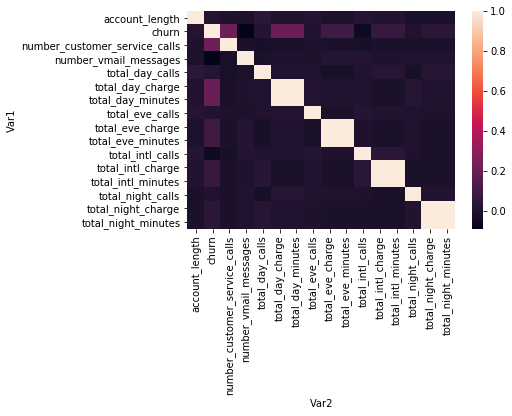

In [17]:
#criando Heatmap de correlação 
sns.heatmap(cors.pivot(index="Var1",columns="Var2", values="Cor"))

Pode-se observar uma correlação mais forte do atributo churn com os atributos number_customer_service_calls, total_day_minutes e total_day_charge

In [18]:
#avaliando a correlação da variável churn com outras variáveis
cors.loc[cors["Var1"]=="churn",].sort_values(by="Cor", ascending=False).head()

,Var1,Var2,Cor
255,churn,churn,1.000000
254,churn,number_customer_service_calls,0.208750
242,churn,total_day_minutes,0.205151
244,churn,total_day_charge,0.205151
245,churn,total_eve_minutes,0.092796


Apesar de fraca, a correlação com essas três variáveis está acima de 0.20, equanto que a quarta variável com maior correlação está abaixo de 0.10

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B3FA594DA0>]],
      dtype=object)

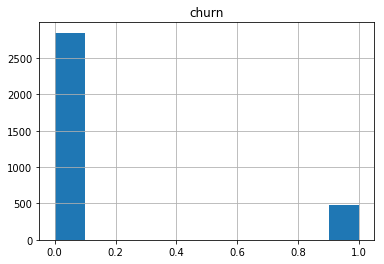

In [20]:
#verificando o balanceamento da variável target
treinoDF.select("churn").toPandas().hist()

A variável target está desbalanceada, sendo que o valor 0 predomina na maioria dos registros.

In [21]:
#funcão para reduzir dimensionalidade horizontal do dataframe, essa função coloca atributos dispostos em várias colunas
#para apenas duas, uma contendo o nome do atributo e outra contendo o valor
def melt(
        df: DataFrame, 
        id_vars: Iterable[str], value_vars: Iterable[str], 
        var_name: str="variavel", value_name: str="valor") -> DataFrame:

    _vars_and_vals = F.array(*(
        F.struct(F.lit(c).alias(var_name), F.col(c).alias(value_name)) 
        for c in value_vars))

    _tmp = df.withColumn("_vars_and_vals", F.explode(_vars_and_vals))

    cols = id_vars + [
            F.col("_vars_and_vals")[x].alias(x) for x in [var_name, value_name]]
    return _tmp.select(*cols)

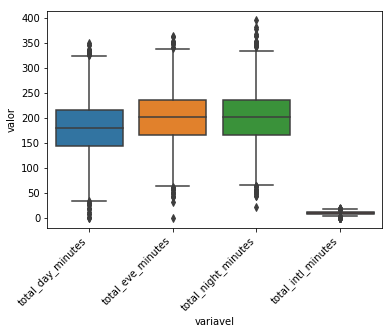

In [22]:
#boxplot do tempo gasto em ligações
tmp = melt(treinoDF.select("id","total_day_minutes","total_eve_minutes","total_night_minutes","total_intl_minutes"), 
     id_vars=["id"], value_vars=["total_day_minutes","total_eve_minutes","total_night_minutes","total_intl_minutes"]).toPandas()
chrt = sns.boxplot(y=tmp.valor, x=tmp.variavel)
rt = chrt.set_xticklabels(chrt.get_xticklabels(), rotation=45, horizontalalignment='right')

Conforme pode-se observar no gráfico acima, as pessoas gastam mais tempo no telefone ao final da tarde e a noite, já o tempo gasto em chamadas internacionais é bastante baixo, isso pode ocorrer em função do custo desse tipo de ligação, ou até mesmo por as pessoas terem a maioria dos seus contatos próximos e não há necessidade na realização de chamadas desse tipo.

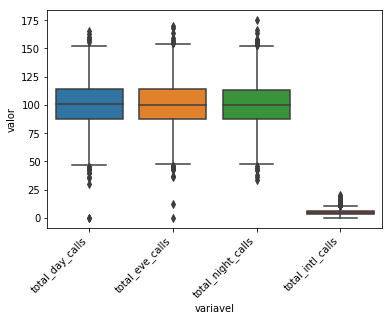

In [23]:
#boxplot da quantidade de ligações
tmp = melt(treinoDF.select("id","total_day_calls","total_eve_calls","total_night_calls","total_intl_calls"), 
     id_vars=["id"], value_vars=["total_day_calls","total_eve_calls","total_night_calls","total_intl_calls"]).toPandas()
chrt = sns.boxplot(y=tmp.valor, x=tmp.variavel)
rt = chrt.set_xticklabels(chrt.get_xticklabels(), rotation=45, horizontalalignment='right')

Analisando o gráfico com a quantidade de ligações, pode-se observar que a quantidade de ligações realizadas durante o dia, é muito parecida com as quantidades realizadas ao final da tarde e a noite, com isso, pod-se concluir que o tempo médio de cada ligação efetuada ao final da tarde e a noite, é maior que o tempo médio das ligações durante o dia. Com relação as ligações internacionais, assim como o tempo gasto, a quantidade de ligações também é bastante inferior as demais.

In [24]:
#criando novos atributos de tempo médio das ligações 
treinoDF = treinoDF.withColumn("md_day_minute", F.col("total_day_minutes")/F.col("total_day_calls"))
treinoDF = treinoDF.withColumn("md_eve_minute", F.col("total_eve_minutes")/F.col("total_eve_calls"))
treinoDF = treinoDF.withColumn("md_night_minute", F.col("total_night_minutes")/F.col("total_night_calls"))
treinoDF = treinoDF.withColumn("md_intl_minute", F.col("total_intl_minutes")/F.col("total_intl_calls"))

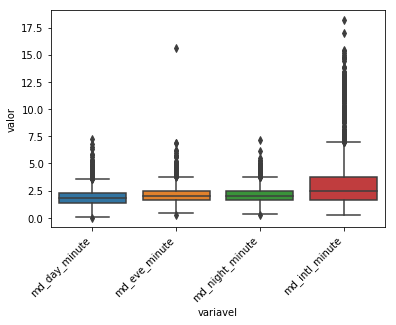

In [25]:
#boxplot do tempo médio das ligações
tmp = melt(treinoDF.select("id","md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"), 
     id_vars=["id"], value_vars=["md_day_minute","md_eve_minute","md_night_minute","md_intl_minute"]).toPandas()
chrt = sns.boxplot(y=tmp.valor, x=tmp.variavel)
rt = chrt.set_xticklabels(chrt.get_xticklabels(), rotation=45, horizontalalignment='right')

O gráfico acima evidencia que o tempo médio das ligações ao final da tarde e a noite estão um pouco acima do tempo médio gasto durante o dia. O que não havia ficado claro nos gráficos anteriores e foi evidenciado nesse gráfico foi o tempo médio da ligações internacionais, esse está acima dos demais, isso mostra uma tendência de que esse serviço seja menos usado que os demais por falta de necessidade, e não pelo alto custo, pois se existisse uma preocupação com o custo da ligação por parte dos clientes, é provável que o tempo médio estaria mais próximo das demais modalidades aqui listadas.

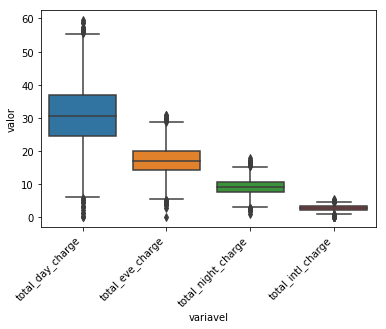

In [26]:
#boxplot de valor gasto
tmp = melt(treinoDF.select("id","total_day_charge", "total_eve_charge", "total_night_charge", "total_intl_charge"), 
     id_vars=["id"], value_vars=["total_day_charge", "total_eve_charge", "total_night_charge", "total_intl_charge"]).toPandas()
chrt = sns.boxplot(y=tmp.valor, x=tmp.variavel)
rt = chrt.set_xticklabels(chrt.get_xticklabels(), rotation=45, horizontalalignment='right')

O boxplot acima evidencia que o período mais rentável para a operadora é durante o dia, apesar do tempo gasto em ligações ao final da tarde e durante a noite serem em geral um pouco maior que durante o dia, o valor cobrado durante o dia em geral é maior que nos demais períodos.

In [27]:
#criando atributos com o tempo total cobrado por cliente e quantidade total de ligações por cliente
treinoDF = treinoDF.withColumn("total_ligacoes", F.col("total_day_calls") + F.col("total_eve_calls") + F.col("total_night_calls") + F.col("total_intl_calls"))
treinoDF = treinoDF.withColumn("total_cobrado", F.col("total_day_charge") + F.col("total_eve_charge") + F.col("total_night_charge") + F.col("total_intl_charge"))

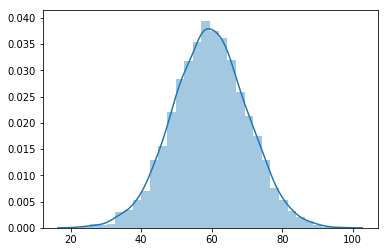

In [28]:
#histograma do valor total cobrado
sns.distplot(treinoDF.select("total_cobrado").toPandas(), bins=30)

A distribução do total dos valores cobrados, segue a tendência de uma distribuição normal

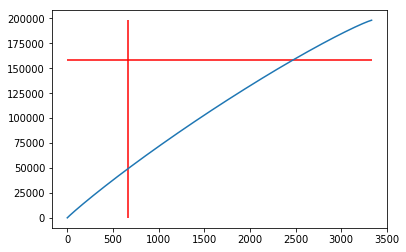

In [29]:
#gráfico valor acumulado pago pelos clientes de forma descrescente
chrt = plt.plot(range(0,treinoDF.count()),treinoDF.select("total_cobrado").toPandas().sort_values(by="total_cobrado",ascending=False).cumsum()["total_cobrado"], '-')
chrt = plt.hlines(np.sum(treinoDF.select("total_cobrado").collect())*0.8,0,treinoDF.count(), colors="red")
chrt = plt.vlines(treinoDF.count()*0.2,0,np.sum(treinoDF.select("total_cobrado").collect()), colors="red")

O gráfico acima mostra o valor cobrado acumulado dos clientes de forma descrescente, ou seja, os clientes que mais pagaram estão a esquerda e os que menos pagaram estão a direita, a linha vermelha horizontal corresponde a 80% de todo o valor pago, já a linha vermelha vertical, corresponde a 20% dos clientes que mais pagaram. Nesse caso, os 20% dos clientes que mais pagaram em valor, pagaram aproximadamente 25% do valor total, essa divisão pode ser considerada balanceada. 

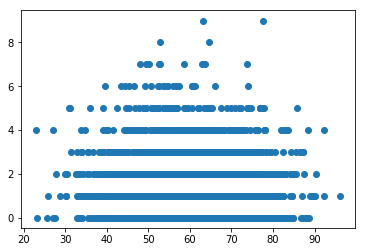

In [30]:
#comparando o número de ligações para o serviço ao cliente
tmp = treinoDF.select("total_cobrado", "number_customer_service_calls").toPandas()
plt.scatter(tmp["total_cobrado"],tmp["number_customer_service_calls"])

Salvo algumas exceções, o intervalo de valores cobrados diminuí conforme o número de ligações ao serviço de atendimento aumenta, sendo que a maioria dos clientes que ligaram mais de 4 vezes para o serviço de atendimento, encontra-se mais próximo da média de valores pagos.

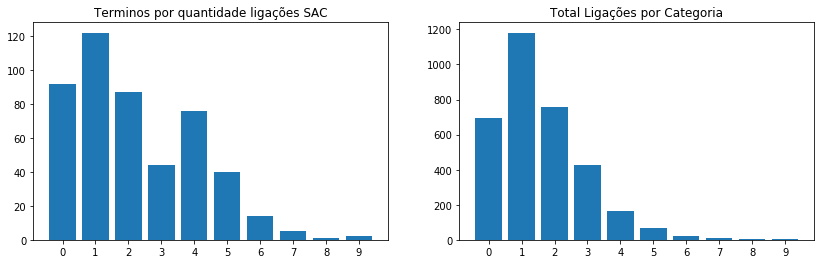

In [31]:
#numero de cancelamentos X quantidade de ligações para o serviço ao cliente (barplot)
tmp = treinoDF.select("number_customer_service_calls","churn").groupBy("number_customer_service_calls").agg(F.sum("churn"), F.count("number_customer_service_calls")).toPandas()
plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
plt.bar(tmp["number_customer_service_calls"],tmp["sum(churn)"])
plt.title('Terminos por quantidade ligações SAC')
tcks = plt.xticks(range(0,10))

plt.subplot(1, 2, 2)
plt.bar(tmp["number_customer_service_calls"],tmp["count(number_customer_service_calls)"])
plt.title('Total Ligações por Categoria')
tcks = plt.xticks(range(0,10))

Dentro das categorias de ligações, os clientes que mais cancelaram foram aqueles que fizeram apenas um contato para a central de atendimento, porém nos dados gerais, essa categoria também é a que possuí o maior número de registros. Nos dados gerais, com exceção dos clientes que não tiveram nenhum contato com o SAC, quanto maior o número de ligações para a central de atendimento, menos registros essa categoria possuí, já analisando os cancelamentos, essa tendência só se repete a partir da categoria 5.

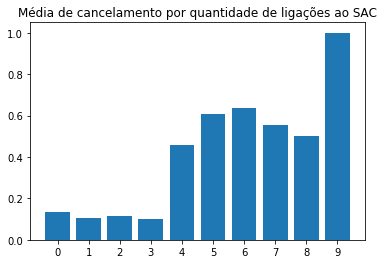

In [32]:
#média de cancelamento por quantidade de ligação para o serviço ao cliente
plt.bar(tmp["number_customer_service_calls"],tmp["sum(churn)"]/tmp["count(number_customer_service_calls)"])
plt.title('Média de cancelamento por quantidade de ligações ao SAC')
tcks = plt.xticks(range(0,10))

Analisando a média de cancelamento, quanto mais ligações foram feitas ao SAC, maior foi a incidência de cancelamento por parte do cliente. <br><br>
Nesse notebook pode-se conhecer um pouco dos dados e as relações que os atributos possuem entre si. No próximo notebook os dados serão preparados e serão aplicados os modelos de learning.